## Dependent and Independent State Transition Assumptions


*Note*: This section is work in progress, the notation is not consistent, the separation of topics not
fully worked out and I am presenting only examples (while hoping to get to a clearer view on the general case).

Consider the case when there are two sources of decrement for a given state in a time step, e.g.:

  * let $q$ denote the probability of death
  * let $r$ denote the probability of lapse
 

Let's assume that both assumptions have been derived independently. This is, e.g., the case when 
during the derivation of these transition assumptions the other cause of decrement was eliminated 
by considering the expsure time for one decrement only.

In this case the assumptions can not directly used as state transition assumptions by ```PyProtolinc```.

In [1]:
import math
import numpy as np

# let's set the lapse rate to 50% and the death rate to 1%
q = 0.01
r = 0.5

It is intuitively clear that due to the high probabilty for lapses there are effectively less than 1% death cases
when considering both forces at work. More specificall we can argue that on average over the year there are only ~75% exposed to death so 
that the effective death rate should be somewhere near 0.0075. We look at the equations in the continuous model:

$$
\begin{array}{ccc}
l(t)    &=& \int_0^t(f_q(s) + f_r(s))l(s)ds\\
l_0q^d(t) &=& \int_0^tf_q(s)l(s)ds\\
l_0r^r(t) &=& \int_0^tf_r(s)l(s)ds
\end{array} 
$$

Here the *forces of decrement* $f_q$ and $f_r$ from the independent decrements have been incorporated and $q^d$ and $r^d$ respectively denote the
*dependent* transition assumptions. Under the *additional assumption* that these
forces are constant between times $0$ and $1$ we can then solve the equations to find first:

$$
l(t) = l_0\exp(-(f_q+f_r)t) = l_0 p(t)
$$

and based on this
$$
\begin{array}{ccccc}
q^d(t) &=& f_q\int_0^t\exp(-(f_q+f_r)s)ds &=& -\frac{f_q}{f_q+f_r}p(s)|^t_0 &=& \frac{f_q}{f_q+f_r}(1 - p(t))\\
r^d(t) &=& f_r\int_0^t\exp(-(f_q+f_r)s)ds &=& -\frac{f_r}{f_q+f_r}p(s)|^t_0 &=& \frac{f_r}{f_q+f_r}(1 - p(t))
\end{array} 
$$


Note that on the other hand we have the equation

$$
q = q^i(1) = f_q\int_0^1\exp(-f_qs)ds = -\exp(-f_qs)|^1_0 = 1 - \exp(-f_q)
$$

for the independent assumptions $q^i$ (and similar for $r^i$) when assuming *constant force for this case as well*.

Consequently $f_q = - \ln(1-q)$ and analogously $f_r = - \ln(1-r)$

For the numerical example this implies

In [2]:
f_q = -math.log(1 - q)
f_r = -math.log(1 - r)
f_q, f_r

(0.01005033585350145, 0.6931471805599453)

This translates to the dependent transition assumptions on the yearly grid as follows:

In [3]:
f = f_q + f_r
p = math.exp(-f)
q_d = f_q * (1 - p) / f
r_d = f_r * (1 - p) / f
q_d, r_d

(0.007217630164430397, 0.4977823698355696)

As expected on can see a small reduction of the lapse rate and a significant adjustment (in relative terms) for
the mortality when comparing with the independent rates (and the value of 0.0072 is close to what we have expected).

The formulae obtained can also directly by used to convert independent assumptions to dependent assumptions valid for *fractions of the year*.

In [4]:
def mort_and_lapse_for_fractions(q, r, t):
    """ Return a 'dependent transition matrix' for a model with two independent
        decrements :q and :r for the time span t. """
    assert 0 <= t and t <= 1
    
    f_q = -math.log(1 - q)
    f_r = -math.log(1 - r)
    f = f_q + f_r
    p_t = math.exp(-f * t)
    q_d = f_q * (1 - p_t) / f
    r_d = f_r * (1 - p_t) / f
    
    M_frac = np.array([[1 - q_d - r_d, q_d, r_d],
                       [0, 1, 0],
                       [0, 0, 1]])
    return M_frac

M4 = mort_and_lapse_for_fractions(q, r, 0.25)
M4

array([[0.83878624, 0.00230412, 0.15890963],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ]])

Applying this state transition matrix four times we get back what we have calculated above.

In [5]:
np.linalg.matrix_power(M4, 4)

array([[0.495     , 0.00721763, 0.49778237],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ]])

### State Transition Example with Two-Way Interactions

We study another example which differs in the sense that we allow transitions between
two states in both directions. The annual dependent state transition matrix
should therefore look as follows

$$
  \left[ {\begin{array}{cc}
    p_1 & q^d\\
    r^d   & p_2\\
  \end{array} } \right]
$$


One can interpret the states as an *active* and a *disabled* with transitions corresponding with *incidence* and *recovery*.

Denoting the *forces of mortality* based on the independent decrements by $f_q$ and $f_r$ we get the following
system describing the evolution of the state volume:
$$
\begin{array}{ccc}
    p_1(t) &=& p_1^0 + \int_0^t \left(-f_q(s)p_1(s) + f_r(s)p_2(s) \right)ds\\
    p_2(t) &=& p_2^0 + \int_0^t \left(f_q(s)p_1(s) - f_r(s)p_2(s) \right)ds\\
\end{array}
$$




Differentiating and using the constant force assumption this becomes the following linear system with constant coefficients:
 
$$
\left(\begin{array}{c}
    p_1\\
    p_2\\
\end{array}\right)' = \left(\begin{array}{cc}
    -f_q & f_r\\
    f_q & -f_r\\
\end{array}\right)
\left(\begin{array}{c}
    p_1\\
    p_2\\
\end{array}\right)
$$

Denoting the matrix on the right hand side by $A$ the solution is given by the general theory as

$$
\left(\begin{array}{c}
    p_1(t)\\
    p_2(t)\\
\end{array}\right) = \exp(tA)\left(\begin{array}{c}
    p_1^0\\
    p_2^0\\
\end{array}\right)
$$


In this case we can solve the system *by hand*: Looking at $\det(A - \lambda E)=0$ we find the eigen values $\lambda_1 = -(f_q+f_r)$ and  $\lambda_2 = 0$ with corresponding eigenvectors
$$\left(\begin{array}{c}
    1\\
    -1\\
\end{array}\right), \left(\begin{array}{c}
    f_r\\
    f_q\\
\end{array}\right)
$$

When setting
$$ M = \left(\begin{array}{cc}
    1 & f_r\\
    -1 & f_q\\
\end{array}\right)
$$
we hence get 
$$
\exp(tA) = M \left(\begin{array}{cc}
    \exp(-(f_q+f_r)t) & 0\\
    0 & 1\\
\end{array}\right) M^{-1}
$$

A calculations then yields
$$
\exp(tA) = \frac{1}{f_q+f_r} \left(\begin{array}{cc}
    f_q  e^{-t(f_q+f_r)} + f_r & f_r (1 - e^{-t(f_q+f_r)}) \\
    f_q (1 - e^{-t(f_q+f_r)})  & f_r e^{-t(f_q+f_r)}) + f_q\\
\end{array}\right)
$$

### Example

As before we use the relations $f_q = - \ln(1-q)$ and $f_r = - \ln(1-r)$ and start with *independent* transition probabilities $q=0.01$ and $r=0.5$ as above. Furthermore assume that at $t=0$ we have $p_1^0 = 0.4$ and $p_2^0 = 0.6$.

In [12]:
def state_evolution_matrix(q, r, t):
    """ Calculate the state evolution matrix after time :t for the 
        independent transitions probabilities q and r in a 2x2 state transition model.
    """
    f_q = -math.log(1 - q)
    f_r = -math.log(1 - r)
    f = f_q + f_r
    e = math.exp(-f * t)
    return (1 / f) * np.array([[f_q * e + f_r, f_r * (1 - e)], [f_q * (1 - e),  f_r * e + f_q]])

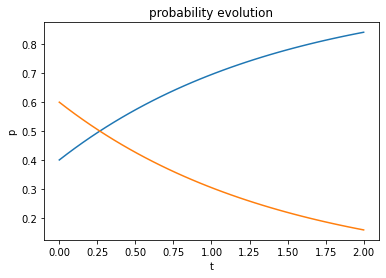

In [13]:
import matplotlib.pyplot as plt

# start state
p1_0 = 0.4
p2_0 = 1 - p1_0
p = np.array([[p1_0], [p2_0]])

# evolving the state
state_no = 40
states = np.zeros((state_no, 2))

ind = 0
for t in np.linspace(0, 2, num=state_no):
    states[ind, :] = state_evolution_matrix(q, r, t=t).dot(p).reshape((2,))
    ind += 1

plt.plot(np.linspace(0, 2, num=state_no), states)
plt.xlabel('t')
plt.ylabel('p') 
plt.title('probability evolution')
plt.show()

In this example we have calculated the transitions for each timestep again starting at $t=0$ and using a time 
dependent matrix. Alternatively we can iterate using the matrix obtained for a small timestep.

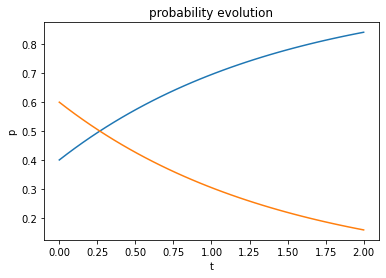

In [14]:
states2 = np.zeros((state_no, 2))
M = state_evolution_matrix(q, r, t=2/39)

states2[0, :] = np.array([p1_0, p2_0])
for ind in range(1, state_no ):
    states2[ind, :] = M.dot(states2[ind - 1, :])

plt.plot(np.linspace(0, 2, num=state_no), states2)
plt.xlabel('t')
plt.ylabel('p') 
plt.title('probability evolution');

At this stage we know the probability distribution of the states over time but we don't know *how many* transitions have actually taken place (because these net so some extent). To find those (using the constant force assumption again) we still need to integrate over the state probabilities.

### General Procedure for the 3x3 Case

Consider a system with three states and *independent* state transition assumptions given in a matrix:

  * $q_{ij}$ denotes the independent transition probability from state *i* to state *j*

In a first step we convert these assumptions to a matrix of constant forces as follows:

  * $f_{ij} = -\ln(1 - q_{ij})$ for $i \neq j$
 
Based on this we can now generate the state evolution differential as follows:

$$ A = \left(\begin{array}{ccc}
    -(f_{12}+f_{13})  &            f_{21} & f_{31} \\
    f_{12}            & -(f_{21}+f_{23})  & f_{32} \\
    f_{13}            &            f_{23} & -(f_{31}+f_{32})\\
\end{array}\right)
$$
We note the column sums are zero.

For a given timestep $\tau$, e.g. one month, we now solve the system
$$ p' = Ap$$ numerically (e.g. Euler, Heun). It needs to be decided if that should be done using
one specific set of initial values or whether that should be done generically using basis
vectors in the space of the initial values (i.e. three independent solutions in this case).
In passing (or afterwards) we calculate also the integrals of the solutions over the timestep (specific or general solution).

We obtain:
  * $p_j = p_j(t) (j=1, \ldots, n, t \in [0, \tau])$ solution with $p_j(0) = p_j^0$
  * $I_j = \int_0^\tau p_j(t)dt (j=1, \ldots, n)$.

Finally we calculate the *dependent probabilitiy transitions* for a discrete timestep $\tau$ as follows:

  * $q^d_{ij} = f_{ij} * I_i$ where $i \neq j$. These values represent the absolute probability that a state transition  $i \rightarrow j$ will take place in the time interval of length $\tau$.
  
 

## Assumptions for Fractions of a Year

In sections the options for adjusting yearly assumptions for different timesteps are discussed. Let's start the discussion by looking at two options described in section 2.6 of Gerber's book *Life Insurance Mathematics*.

We start with a simple example including two states, one representing the active phase (or, e.g., the state of an annuity in payment) and a terminal state. Usually the the decrement assumption is then specified by a mortality rate `q` which described the probability of an individual to transition from *active* to *death*  in the course of one year.

A state transition matrix would then look as follows:

In [ ]:
q = 0.02
M = np.array([[1 - q, q], [0, 1]])
M

### Constant Force Transitions with One State Transition

In the case described in this section one considers the so-called *force of mortality* (denoted by $f$ below) to be constant.

To understand that consider the continous setup where the evolution of the *actives portfolio* would be noted by $l(t)$ and described by the equation

$$
1 - l(t) = \int_0^tf(s)l(s)ds
$$


In general $f$ is time dependent but if one assumes that $f$ is a constant, then we can differentiate to find

$$ -l'(t) = l(t)f$$

which implies that $l(t) = l_0\exp(-ft)$.

Considering that for $t=1$ we have $l(1) = l_0(1 - q)$ we can conclude that $f = -\ln(1-q)$.

Consequently we can now calculate *fractional transition matrices* by noting that for $t \in [0, 1]$ we have
$$ l(t) = l_0\exp(-ft) = l_0\exp(t\ln(1-q)) = l_0 (1-q)^t. $$

This translates into the following transition matrix for $t = 0.5$:

In [ ]:
def m_t_const_force(q, t):
    return np.array([[(1 - q)**t, 1 - (1 - q)**t], [0, 1]])

M2 = m_t_const_force(q, 0.5)
M2

We can multiply back to confirm the expected:

In [ ]:
np.dot(M2, M2)

And similarly

In [ ]:
M12 = m_t_const_force(q, 1/12)
M12

In [ ]:
np.linalg.matrix_power(M12, 12)

### Linearity of q

An alternative method is obtained when assuming that $_uq = uq$.

In [ ]:
def m_t_linear(q, t):
    return np.array([[1 - q*t, q*t], [0, 1]])

L2 = m_t_linear(q, 0.5)
L2

In [ ]:
np.dot(L2, L2)

In this case the calculation is simpler but not exact.

In [ ]:
L12 = m_t_linear(q, 1/12)
L12

In [ ]:
np.linalg.matrix_power(L12, 12)

This problem becomes more severe for higher values of $q$, for example we take q = 1:

In [ ]:
L2 = m_t_linear(0.9, 0.5)
np.dot(L2, L2)

We see that more than 30% survive while there should be only 10%. Note that this works as expected for the constant force method.

In [ ]:
L2 = m_t_const_force(0.9, 0.5)
np.dot(L2, L2)

### Constant Force Transitions with Two Decrements

Next we look at the case with one active state and two decrements. A transition matrix on the yearly grid would look like this whereby $q$ and $r$ represent the **dependent** yearly transition probabilities.

$$
  \left[ {\begin{array}{ccc}
    1 - q - r & q & r \\
    0         & 1 & 0 \\
    0         & 0 & 1 \\
  \end{array} } \right]
$$

We proceed as before by writing down the continuous transition equations
assuming *constant force of decrements* for both transitions:

$$
\begin{array}{ccc}
l_0q(t) &=& \int_0^tf_ql(s)ds\\
l_0r(t) &=& \int_0^tf_rl(s)ds
\end{array} 
$$

Adding the equations and noting that $l(t) = l_0(1 - q(t) - r(t))$ we find similar to before that 

$$
1 - l(t) = \int_0^t(f_q+f_r)l(s)ds
$$

and consequently $l(t) = l_0\exp(-(f_q+f_r)t)$ and $f_q + f_r = -\ln(1-q-r).$

Using the representation of $l(t)$ in the expression for $q(t)$ one obtains

$$
\begin{array}{ccc}
l_0q(t) &=& \int_0^tf_ql(s)ds\\
        &=& f_q \int_0^tl_0\exp(-(f_q+f_r)t)ds\\
        &=& f_q \int_0^tl_0\exp(-(f_q+f_r)t)ds\\
        &=& -\frac{f_q}{f_q+f_r}l(t)|^t_0.
\end{array}
$$

Consequently
$$
\begin{array}{ccc}
q(t) &=& \frac{f_q}{f_q+f_r}(1 - p(t)), \\
r(t) &=& \frac{f_r}{f_q+f_r}(1 - p(t)),
\end{array} 
$$

Noting that for $t=1$ we have $q(t)=q$, $r(t)=r$ and $1 - p(1) = q + r$, so that we find
$$
\begin{array}{ccc}
q &=& \frac{f_q}{f_q+f_r}(q + r), \\
r &=& \frac{f_r}{f_q+f_r}(q + r). \\
\end{array} 
$$
We can now easily obtain the forces from this:
$$
\begin{array}{cccc}
f_q &=& \frac{q}{q+r}(f_q+f_r) = -\ln(1-q-r)\frac{q}{q+r}, \\
f_r &=& \frac{r}{q+r}(f_q+f_r) = -\ln(1-q-r)\frac{r}{q+r}. \\
\end{array} 
$$

We continue with a numerical example:

In [ ]:
q = 0.1
r = 0.01
M = np.array([[1 - q - r, q, r],
              [0, 1, 0],
              [0, 0, 1]])
M

In [ ]:

def fractional_transition(q, r, t):
    """ The function shall return a fractional transition matrix :M for the duration :t."""
    
    f_qr = -math.log(1-q-r)
    
    f_q = f_qr * q / (q + r)
    f_r = f_qr * r / (q + r)
    
    p_t = math.exp(-f_qr * t)   # (1 - q -r)**t
    
    q_t = (1 - p_t) * f_q / f_qr
    r_t = (1 - p_t) * f_r / f_qr
    
    M_frac = np.array([[1 - q_t - r_t, q_t, r_t],
                       [0, 1, 0],
                       [0, 0, 1]])
    return M_frac
    
M2 = fractional_transition(q, r, 0.5)
M2

We check that we get the original matrix back:

In [ ]:
np.dot(M2, M2)

We repeat the check for the monthly transitions:

In [ ]:
M12 = fractional_transition(q, r, 1 / 12)
M12

In [ ]:
np.linalg.matrix_power(M12, 12)